In [1]:
# 載入套件
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ariel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 資料前處理
用 nltk 套件做斷句、斷詞、stemming

In [3]:
maildata = pd.read_csv("Phishing_Email.csv")

In [4]:
# 斷句
maildata = maildata.assign(sentence = maildata['Email Text'].astype(str).apply(nltk.sent_tokenize)).explode('sentence').reset_index(drop=True)

# 刪除標點符號/數字/換行符號
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
maildata['sentence'] = maildata["sentence"].str.replace(r'[\d]+', '', regex=True).astype(str) #去除數字
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格

# 去除空值
# dataset 有些郵件是 empty
# 經過 nltk 套件會有些東西變 nan
maildata = maildata[maildata["sentence"] != "empty"]
maildata = maildata[maildata["sentence"] != "nan"]

# 斷詞
token_df = maildata.assign(token = maildata['sentence'].apply(nltk.word_tokenize)).explode('token').reset_index(drop=True)

# 轉成小寫
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())

In [5]:
# stemming
# porter = PorterStemmer()
# mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(porter.stem)).reset_index(drop=True)

# lemmatization
lm = WordNetLemmatizer()
mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(lm.lemmatize)).reset_index(drop=True)


In [6]:
# 將不必要的欄位 以及 nan 刪掉
tidy_mails_df = mails_df.drop(columns=["token", "word"])
tidy_mails_df = tidy_mails_df.rename(columns={"Unnamed: 0":"index", "stem_token":"word"})
tidy_mails_df = tidy_mails_df[tidy_mails_df['word'] != 'nan']

In [7]:
def is_single_english_letter(word):
    # 使用正則表達式匹配僅包含一個英文字母的字符串
    #return bool(re.fullmatch(r'[a-zA-Z]', word))
    return len(word) <= 1

tidy_mails_df = tidy_mails_df[~tidy_mails_df['word'].apply(is_single_english_letter)]

In [8]:
tidy_mails_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6836675 entries, 0 to 7318687
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   index       int64 
 1   Email Text  object
 2   Email Type  object
 3   sentence    object
 4   word        object
dtypes: int64(1), object(4)
memory usage: 313.0+ MB


### 移除停用字

In [9]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 使用nltk的stop_words
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# 手動加入停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stops.extend(newStops)

In [11]:
noStop_df = tidy_mails_df[~tidy_mails_df['word'].isin(stops)]
noStop_df

,index,Email Text,Email Type,sentence,word
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,disc
2,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,uniformitarianism
4,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,sex
5,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,lang
6,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,dick
...,...,...,...,...,...
7318683,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,team
7318684,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kind
7318685,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,regard
7318686,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kuldeep


以上為資料前處理的部分

## 計算詞頻
下面分為全部字的詞頻、Phishing mail詞頻、Safe mail詞頻

### 總信件字詞頻（刪除停用字後）

In [12]:
freq_noStop_df = pd.DataFrame(noStop_df['word'].value_counts()).reset_index()
freq_noStop_df.columns = ['word', 'freq']
freq_noStop_df.head(30)

,word,freq
0,language,23428
1,enron,19274
2,university,17510
3,information,14703
4,please,13774
5,new,13373
6,subject,12514
7,time,11610
8,company,11540
9,address,11488


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the foll

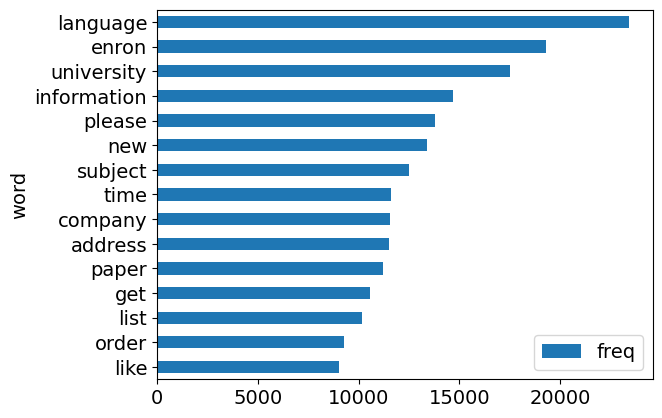

In [13]:
freq_noStop_df.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

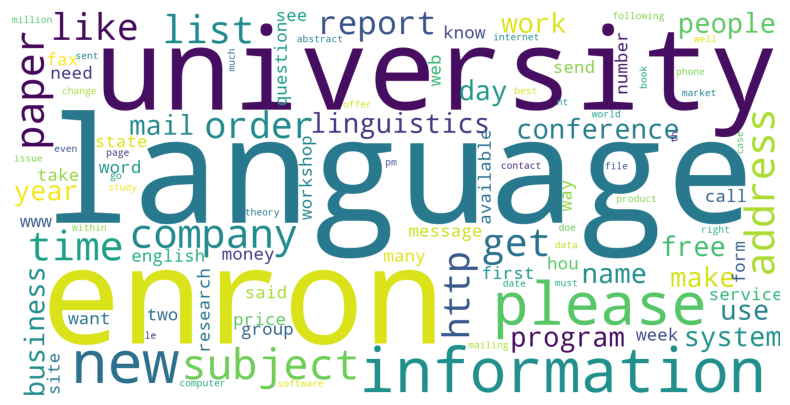

In [14]:
text = freq_noStop_df.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從總信件的詞頻長條圖與文字雲可看出：<br>
1. enron這家公司很常被提到，可能是與安隆事件相關（當年安隆事件的電子郵件至今仍大量散佈在網路上）<br>
2. language也很常出現，可能是因為幾乎每封電子郵件中的廣告都能讓使用者設定語言<br>

接下來會看phishing與safe信件的差異

### Phishing mail 詞頻

In [15]:
final_phishing = noStop_df[noStop_df['Email Type'] == 'Phishing Email']

In [16]:
freq_phishing = pd.DataFrame(final_phishing['word'].value_counts()).reset_index()
freq_phishing.columns = ['word', 'freq']
freq_phishing.head(30)

,word,freq
0,company,5117
1,free,4331
2,get,3985
3,report,3899
4,business,3848
5,please,3844
6,information,3842
7,money,3789
8,order,3687
9,address,3640


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the foll

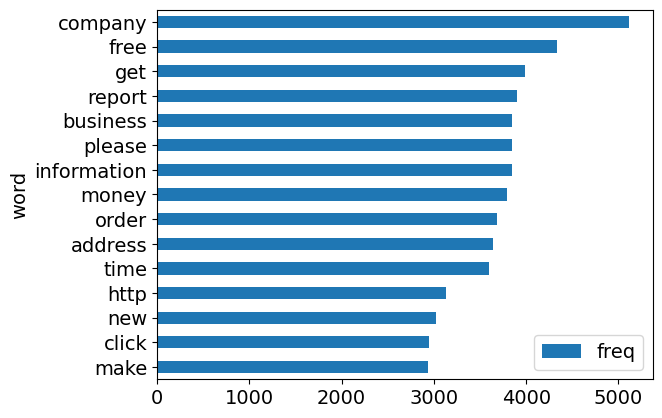

In [17]:
freq_phishing.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

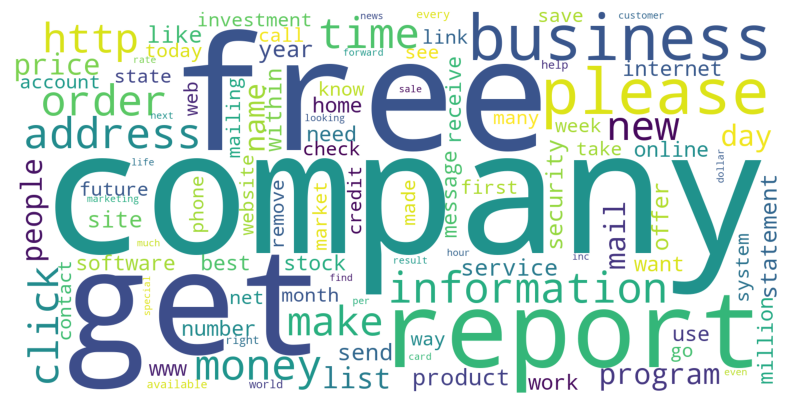

In [18]:
text = freq_phishing.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從phishing信件的詞頻長條圖與文字雲可看出：<br>
1. company很常被提到，可能是部分釣魚信件會偽裝成公司發出<br>
2. free、get、click、money出現頻率很高，推測釣魚信件中經常與金錢有關，且會請使用者點擊連結<br>


### Safe mail 詞頻

In [19]:
final_safe = noStop_df[noStop_df['Email Type'] == 'Safe Email']

In [20]:
freq_safe = pd.DataFrame(final_safe['word'].value_counts()).reset_index()
freq_safe.columns = ['word', 'freq']
freq_safe.head(30)

,word,freq
0,language,23332
1,enron,19271
2,university,17404
3,subject,11429
4,paper,10974
5,information,10861
6,new,10345
7,please,9930
8,linguistics,8908
9,conference,8406


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
findfont: Generic family 'sans-serif' not found because none of the foll

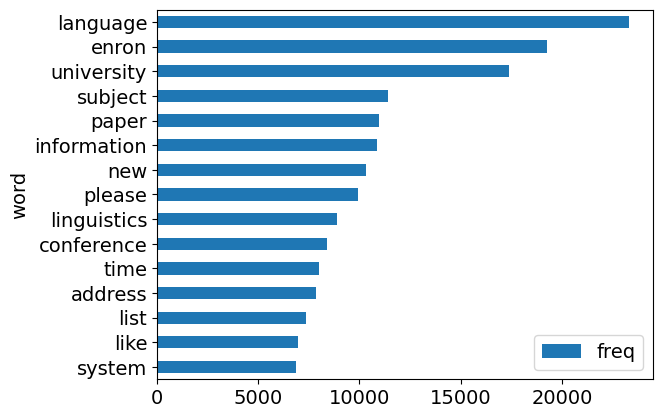

In [21]:
freq_safe.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

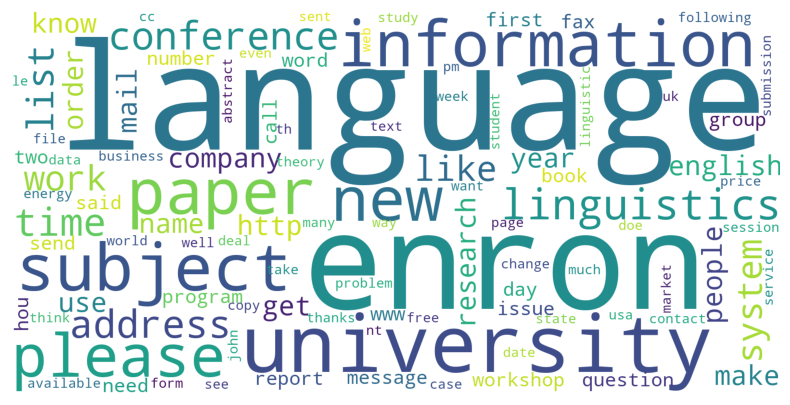

In [22]:
text = freq_safe.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從safe信件的詞頻長條圖與文字雲可看出，基本上phishing信件的高頻詞彙在safe信件中都不常出現，因此推測可用phishing信件的詞頻與文字雲來當作過濾釣魚信件的依據。